In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Wed Sep 18 17:08:52 PDT 2019


# Table of MAM DALYs and delta MAM DALYs by scenario and by location

In [2]:
cat = 'cat2'

In [3]:
%cd /share/costeffectiveness/results/vivarium_conic_sam_comparison

/ihme/costeffectiveness/results/vivarium_conic_sam_comparison


In [4]:
import glob
# sorted(glob.glob('*/*/output.hdf'))

In [5]:
location_list = ['India', 'Bangladesh', 'Pakistan', 'Tanzania', 'Malawi', 'Mali']
fname = {}
for loc in location_list:
    fname[loc] = sorted(glob.glob(f'vivarium_conic_sam_comparison_{loc}/*/output.hdf'))[-1]
fname

{'India': 'vivarium_conic_sam_comparison_India/2019_09_12_14_36_19/output.hdf',
 'Bangladesh': 'vivarium_conic_sam_comparison_Bangladesh/2019_09_12_16_06_24/output.hdf',
 'Pakistan': 'vivarium_conic_sam_comparison_Pakistan/2019_09_12_14_36_44/output.hdf',
 'Tanzania': 'vivarium_conic_sam_comparison_Tanzania/2019_09_12_14_36_50/output.hdf',
 'Malawi': 'vivarium_conic_sam_comparison_Malawi/2019_09_12_14_36_29/output.hdf',
 'Mali': 'vivarium_conic_sam_comparison_Mali/2019_09_12_14_36_37/output.hdf'}

In [6]:
df = {}
for loc in location_list:
    df[loc] = pd.read_hdf(fname[loc])
    print(loc, len(df[loc]))

India 4000
Bangladesh 4000
Pakistan 4000
Tanzania 4000
Malawi 4000
Mali 4000


In [7]:
for loc in location_list:
    del df[loc]['random_seed']

In [8]:
scenarios = ['interventions.BEP_intervention.coverage_proportion',
 'interventions.SQ_LNS_intervention.coverage_proportion',
 'interventions.TF_SAM_intervention.coverage_proportion',]

for loc in location_list:
    g = df[loc].reset_index().groupby(scenarios + ['input_draw_number'])
    print(f'{loc} has {len(g.groups)} groups, with {len(df[loc])/len(g.groups):.2f} reps per group')
    df[loc] = g.sum()


India has 400 groups, with 10.00 reps per group
Bangladesh has 400 groups, with 10.00 reps per group
Pakistan has 400 groups, with 10.00 reps per group
Tanzania has 400 groups, with 10.00 reps per group
Malawi has 400 groups, with 10.00 reps per group
Mali has 400 groups, with 10.00 reps per group


In [9]:
def scenario_map_generator():
    baseline = (0,0,0)
    bep = (.8, 0, 0)
    sqlns = (0, .8, 0)
    tfsam = (0, 0, .8)
    scenario_map = dict(baseline=baseline, bep=bep, sqlns=sqlns, tfsam=tfsam)

    return scenario_map
scenario_map = scenario_map_generator()

In [10]:
cause_list = ('lower_respiratory_infections diarrheal_diseases measles '
              + 'protein_energy_malnutrition ' +'other_causes '
              + 'neonatal_preterm_birth neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma '
              + 'hemolytic_disease_and_other_neonatal_jaundice '
              + 'neonatal_sepsis_and_other_neonatal_infections'
             ).split()

In [11]:
def dalys_per_100k(df, scenario):
    
    scenario = scenario_map[scenario]
    
    # wasting category `cat` person years
    py = df.loc[scenario, f'person_time_in_child_stunting_{cat}']
    dalys = pd.Series(0, index=py.index)
    for outcome in ['ylls', 'ylds']:
        for cause in cause_list:
            if outcome == 'ylds' and cause == 'other_causes':
                continue # YLDs for other causes is not tracked
            key = f'{outcome}_due_to_{cause}_in_child_stunting_{cat}'

            dalys += df.loc[scenario, key]
    
    return 100_000 * dalys / py
dalys_per_100k(df[loc], 'baseline').describe()

count       100.000000
mean     436328.578300
std       49547.566644
min      319509.760523
25%      401384.233355
50%      438548.191139
75%      468419.690566
max      631473.783729
dtype: float64

In [12]:
import pymc as pm

In [13]:
def my_formatted_output_pct(s):
    mu = f'{s.mean():.2f}'
    lb, ub = pm.utils.hpd(s, .05)
    lb = f'{lb:.2f}'
    ub = f'{ub:.2f}'
#     return [f'{mu} ({lb}, {ub})']
    return {'mean':mu, 'lb':lb, 'ub':ub}

In [14]:
def my_formatted_output_dalys(s):
    mu = f'{np.round(s.mean(), -3):.0f}'
    lb, ub = pm.utils.hpd(s, .05)
    lb = f'{np.round(lb, -3):.0f}'
    ub = f'{np.round(ub, -3):.0f}'
#     return [f'{mu} ({lb}, {ub})']
    return {'mean':mu}#, 'lb':lb, 'ub':ub}
my_formatted_output_dalys(dalys_per_100k(df[loc], 'baseline'))

{'mean': '436000'}

In [15]:
results = {}

for loc in location_list:
    val_0 = dalys_per_100k(df[loc], 'baseline')
    for scenario in ['baseline', 'bep', 'sqlns', 'tfsam']:
        val_1 = dalys_per_100k(df[loc], scenario)
        results[loc, scenario, 'dalys'] = my_formatted_output_dalys(val_1)
        if scenario != 'baseline':
            results[loc, scenario, 'dalys_averted'] = my_formatted_output_dalys(val_0-val_1)
            results[loc, scenario, 'pct_averted'] = my_formatted_output_pct(100*(val_0-val_1)/val_0)
results = pd.DataFrame(results)        

In [16]:
results = results.T.unstack().unstack().dropna(axis=1, how='all')

In [17]:
# col_to_sort = (0, 'pct', 'baseline')
col_to_sort = ('mean', 'dalys', 'baseline')
results.sort_values(col_to_sort, ascending=False)

mean                                                     \
              dalys                         dalys_averted                
           baseline     bep   sqlns   tfsam           bep  sqlns tfsam   
Bangladesh    98000   88000   96000   98000         10000   2000     0   
Mali         436000  390000  425000  436000         46000  11000     0   
Malawi       367000  309000  354000  367000         58000  13000     0   
Tanzania     359000  304000  347000  358000         54000  12000  1000   
Pakistan     170000  154000  167000  170000         15000   3000     0   
India        111000  101000  109000  111000          9000   1000     0   

                                            lb                       ub        \
           pct_averted             pct_averted              pct_averted         
                   bep sqlns tfsam         bep sqlns  tfsam         bep sqlns   
Bangladesh       10.12  1.68  0.04        5.99  0.59   0.01       14.02  2.68   
Mali             10.59  2.50  0.04        8.55  1.49  -0.05       12.37  3.74   
Malawi           15.78  3.65  0.05       12.73  2.02  -0.09       18.78  5.03   
Tanzania         15.13  3.37  0.27       12.79  2.08  -0.09       17.94  4.85   
Pakistan          8.97  1.59  0.04        6.11  0.65  -0.02       11.50  2.54   
India             8.42  1.28  0.06        6.14  0.46  -0.10       10.57  2.21   

                  
                  
           tfsam  
Bangladesh  0.06  
Mali        0.17  
Malawi      0.19  
Tanzania    1.32  
Pakistan    0.12  
India       0.21

In [18]:
results.loc[location_list]

mean                                                     \
              dalys                         dalys_averted                
           baseline     bep   sqlns   tfsam           bep  sqlns tfsam   
India        111000  101000  109000  111000          9000   1000     0   
Bangladesh    98000   88000   96000   98000         10000   2000     0   
Pakistan     170000  154000  167000  170000         15000   3000     0   
Tanzania     359000  304000  347000  358000         54000  12000  1000   
Malawi       367000  309000  354000  367000         58000  13000     0   
Mali         436000  390000  425000  436000         46000  11000     0   

                                            lb                       ub        \
           pct_averted             pct_averted              pct_averted         
                   bep sqlns tfsam         bep sqlns  tfsam         bep sqlns   
India             8.42  1.28  0.06        6.14  0.46  -0.10       10.57  2.21   
Bangladesh       10.12  1.68  0.04        5.99  0.59   0.01       14.02  2.68   
Pakistan          8.97  1.59  0.04        6.11  0.65  -0.02       11.50  2.54   
Tanzania         15.13  3.37  0.27       12.79  2.08  -0.09       17.94  4.85   
Malawi           15.78  3.65  0.05       12.73  2.02  -0.09       18.78  5.03   
Mali             10.59  2.50  0.04        8.55  1.49  -0.05       12.37  3.74   

                  
                  
           tfsam  
India       0.21  
Bangladesh  0.06  
Pakistan    0.12  
Tanzania    1.32  
Malawi      0.19  
Mali        0.17

# Figures for presentation

In [19]:
import seaborn as sns
sns.set_context('talk', font_scale=1.5)

def set_plot_size():
    from IPython.core.pylabtools import figsize
    figsize(11, 5.5)
set_plot_size()

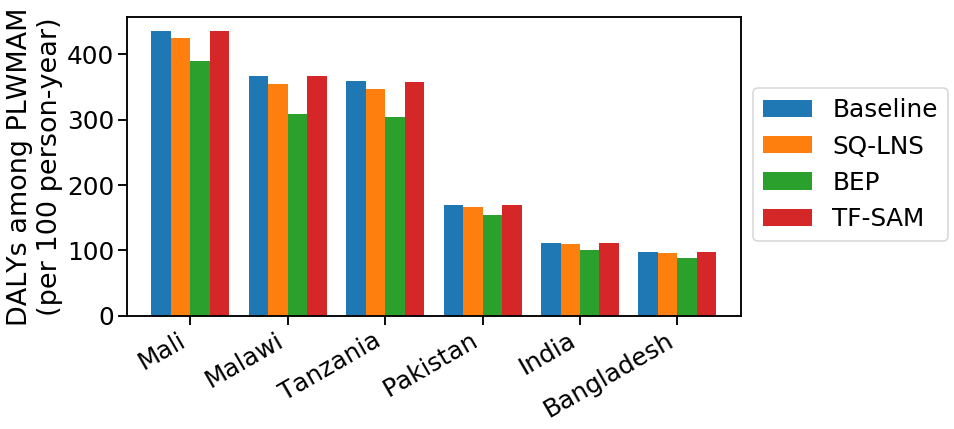

In [20]:
def my_plot(cols_to_blank=[]):
    t = (results.loc[location_list, ('mean', 'dalys')].astype(float)/1_000)\
        .filter(['baseline', 'sqlns', 'bep', 'tfsam'])
    t.loc[:, cols_to_blank] = 0
    
    t.columns = ['Baseline', 'SQ-LNS', 'BEP', 'TF-SAM']
    t = t.sort_values('Baseline', ascending=False)
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))

    plt.ylabel('DALYs among PLWMAM\n(per 100 person-year)')
    plt.xticks(rotation=30, ha='right')
my_plot(cols_to_blank=[])

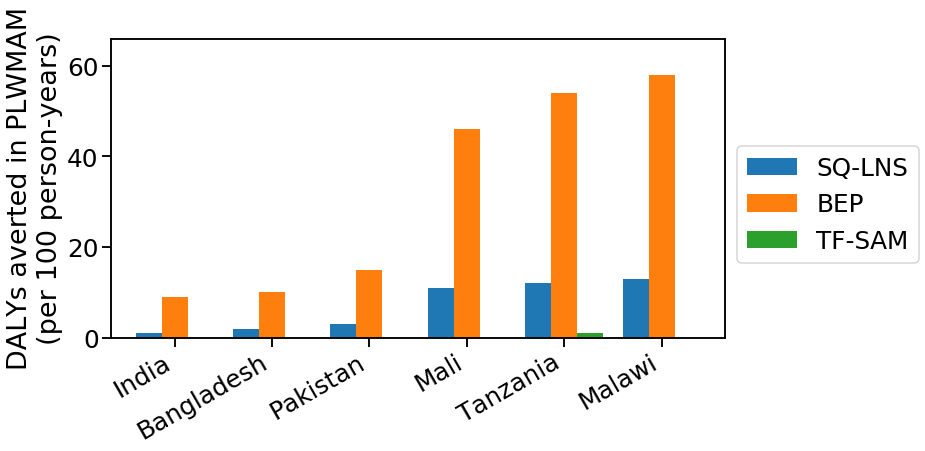

In [21]:
def my_plot(cols_to_blank=[]):
    t = (results.loc[location_list, ('mean', 'dalys_averted')].astype(float)/1_000)\
        .filter(['sqlns', 'bep', 'tfsam'])
    
    t = t.sort_values('bep', ascending=True)
    t.loc[:, cols_to_blank] = 0

    t.columns = ['SQ-LNS', 'BEP', 'TF-SAM']
    
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))
    plt.axis(ymax=66)
    plt.ylabel('DALYs averted in PLWMAM\n(per 100 person-years)')
    plt.xticks(rotation=30, ha='right')
my_plot(cols_to_blank=[])

In [22]:
results.loc[location_list, ('mean', 'dalys_averted')]
# results.loc[location_list, ('mean', 'pct_averted')]

,bep,sqlns,tfsam
India,9000,1000,0
Bangladesh,10000,2000,0
Pakistan,15000,3000,0
Tanzania,54000,12000,1000
Malawi,58000,13000,0
Mali,46000,11000,0


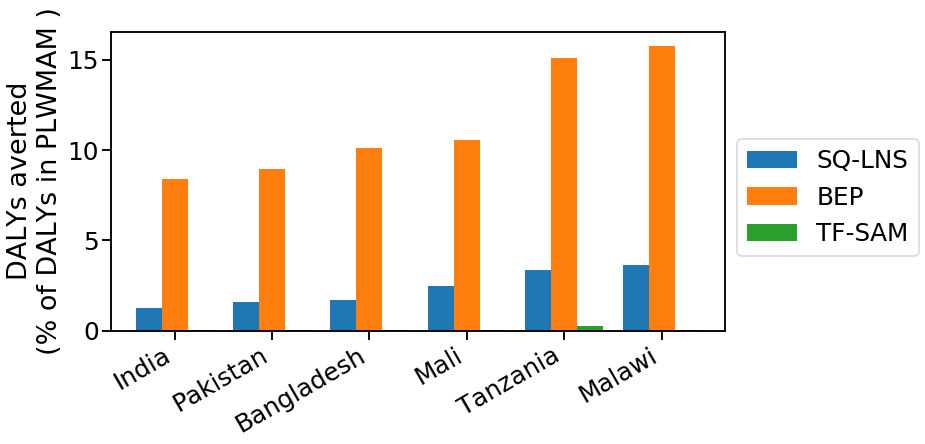

In [23]:
def my_plot(cols_to_blank=[]):
    t = (results.loc[location_list, ('mean', 'pct_averted')].astype(float))\
        .filter(['sqlns', 'bep', 'tfsam'])
    
    t = t.sort_values('bep', ascending=True)
    t.loc[:, cols_to_blank] = 0

    t.columns = ['SQ-LNS', 'BEP', 'TF-SAM']
    
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))
#     plt.axis(ymax=66)
    plt.ylabel('DALYs averted\n(% of DALYs in PLWMAM )')
    plt.xticks(rotation=30, ha='right')
my_plot(cols_to_blank=[])

In [24]:
results.loc[location_list, ('mean', 'pct_averted')]

,bep,sqlns,tfsam
India,8.42,1.28,0.06
Bangladesh,10.12,1.68,0.04
Pakistan,8.97,1.59,0.04
Tanzania,15.13,3.37,0.27
Malawi,15.78,3.65,0.05
Mali,10.59,2.50,0.04


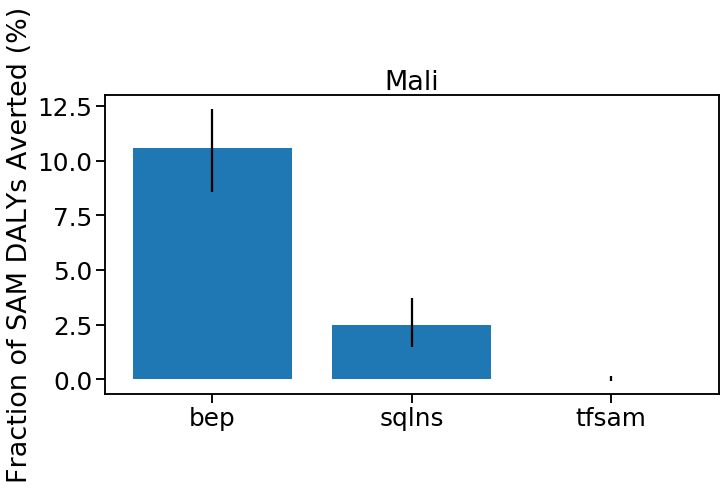

In [25]:
t = results.loc[loc, ('mean', 'pct_averted')]
plt.bar(t.index, t.astype(float).values, bottom=0, yerr=(
   t.astype(float).values-results.loc[loc, ('lb', 'pct_averted')].astype(float),
   results.loc[loc, ('ub', 'pct_averted')].astype(float)-t.astype(float).values,))

plt.ylabel('Fraction of SAM DALYs Averted (%)')
plt.title(loc);

In [26]:
my_formatted_output_pct(dalys_per_100k(df[loc], 'sqlns') - dalys_per_100k(df[loc], 'bep'))

{'mean': '35413.42', 'lb': '24193.02', 'ub': '45695.35'}

In [27]:
my_formatted_output_pct(dalys_per_100k(df[loc], 'tfsam') - dalys_per_100k(df[loc], 'bep'))

{'mean': '46252.79', 'lb': '32415.04', 'ub': '62079.50'}

t = sqlns - bep =  {'mean': '7905.74', 'lb': '4868.98', 'ub': '10268.54'} Pr[t>0] =  1.0 (n = 100)
t = tfsam - bep =  {'mean': '9264.68', 'lb': '6385.18', 'ub': '12037.13'} Pr[t>0] =  1.0 (n = 100)


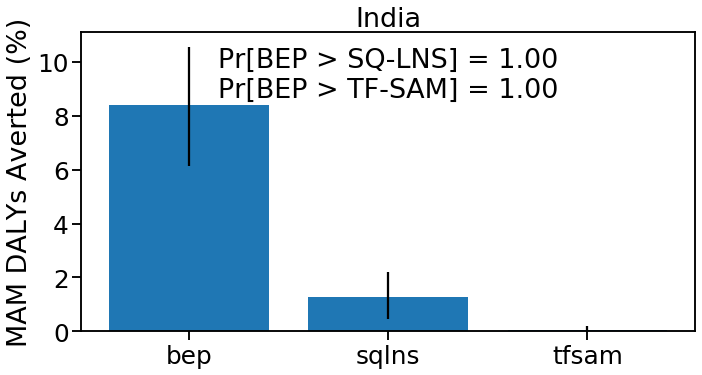

In [28]:
def my_compare(loc):
    t = results.loc[loc, ('mean', 'pct_averted')]
    plt.bar(t.index, t.astype(float).values, bottom=0, yerr=(
       t.astype(float).values-results.loc[loc, ('lb', 'pct_averted')].astype(float),
       results.loc[loc, ('ub', 'pct_averted')].astype(float)-t.astype(float).values,))

    plt.ylabel('MAM DALYs Averted (%)')
    plt.title(loc)
    
    t = dalys_per_100k(df[loc], 'sqlns') - dalys_per_100k(df[loc], 'bep')
    print('t = sqlns - bep = ', my_formatted_output_pct(t), 'Pr[t>0] = ', np.mean(t > 0), f'(n = {len(t)})')
    plt.text(.5, .95, f'Pr[BEP > SQ-LNS] = {np.mean(t > 0):.2f}',
             transform=plt.gca().transAxes, ha='center', va='top')

    t = dalys_per_100k(df[loc], 'tfsam') - dalys_per_100k(df[loc], 'bep')
    print('t = tfsam - bep = ', my_formatted_output_pct(t), 'Pr[t>0] = ', np.mean(t > 0), f'(n = {len(t)})')
    plt.axis(ymin=0)

    plt.text(.5, .95, f'\nPr[BEP > TF-SAM] = {np.mean(t > 0):.2f}',
             transform=plt.gca().transAxes, ha='center', va='top')

my_compare(loc='India')

t = sqlns - bep =  {'mean': '8327.78', 'lb': '4056.75', 'ub': '12943.43'} Pr[t>0] =  1.0 (n = 100)
t = tfsam - bep =  {'mean': '9943.89', 'lb': '5329.97', 'ub': '15613.36'} Pr[t>0] =  1.0 (n = 100)


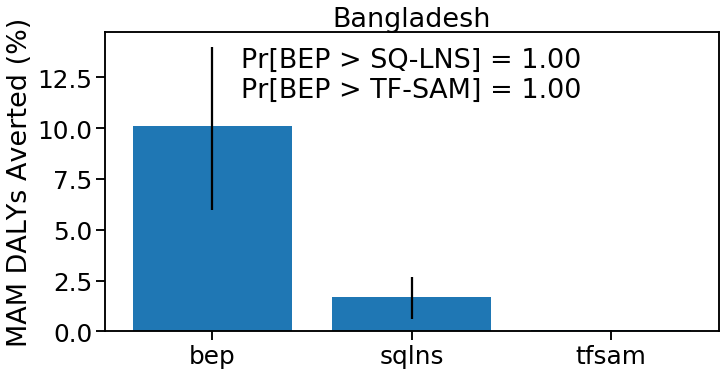

In [29]:
my_compare(loc='Bangladesh')

t = sqlns - bep =  {'mean': '12602.11', 'lb': '7603.98', 'ub': '19025.56'} Pr[t>0] =  1.0 (n = 100)
t = tfsam - bep =  {'mean': '15267.61', 'lb': '8643.39', 'ub': '22123.27'} Pr[t>0] =  1.0 (n = 100)


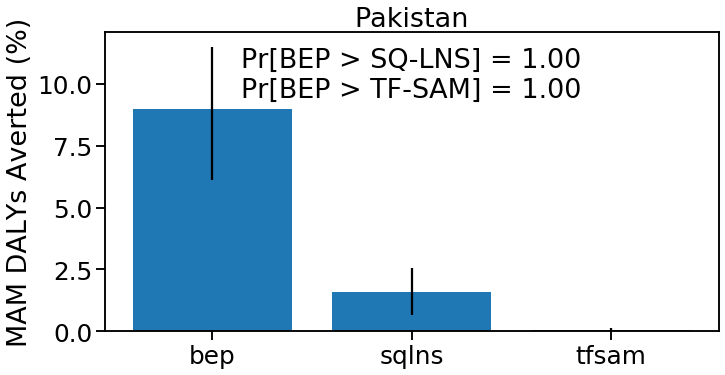

In [30]:
my_compare(loc='Pakistan')

t = sqlns - bep =  {'mean': '44683.23', 'lb': '23815.08', 'ub': '60303.16'} Pr[t>0] =  1.0 (n = 100)
t = tfsam - bep =  {'mean': '57989.69', 'lb': '34303.62', 'ub': '75601.72'} Pr[t>0] =  1.0 (n = 100)


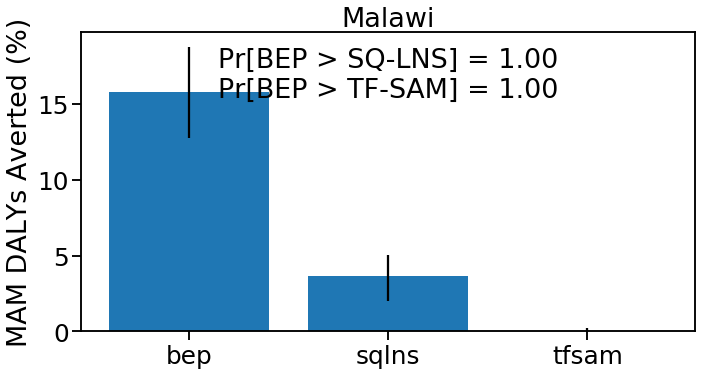

In [31]:
my_compare(loc='Malawi')

In [ ]:
my_compare(loc='Tanzania')

t = sqlns - bep =  {'mean': '42400.53', 'lb': '27000.16', 'ub': '56583.84'} Pr[t>0] =  1.0 (n = 100)
t = tfsam - bep =  {'mean': '53512.65', 'lb': '35390.49', 'ub': '69451.54'} Pr[t>0] =  1.0 (n = 100)


In [ ]:
my_compare(loc='Mali')